In [1]:
import pandas as pd
df = pd.read_csv(r"C:\Users\TahaK\Desktop\ML\Customer-Churn-Predictor\data\Telco-Customer-Churn.csv")
print(df.head)
df.info()
df.isnull().sum()

<bound method NDFrame.head of       customerID  gender  SeniorCitizen Partner Dependents  tenure  \
0     7590-VHVEG  Female              0     Yes         No       1   
1     5575-GNVDE    Male              0      No         No      34   
2     3668-QPYBK    Male              0      No         No       2   
3     7795-CFOCW    Male              0      No         No      45   
4     9237-HQITU  Female              0      No         No       2   
...          ...     ...            ...     ...        ...     ...   
7038  6840-RESVB    Male              0     Yes        Yes      24   
7039  2234-XADUH  Female              0     Yes        Yes      72   
7040  4801-JZAZL  Female              0     Yes        Yes      11   
7041  8361-LTMKD    Male              1     Yes         No       4   
7042  3186-AJIEK    Male              0      No         No      66   

     PhoneService     MultipleLines InternetService OnlineSecurity  ...  \
0              No  No phone service             DSL   

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [2]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

# ---- Step 2: Drop customerID if it exists ----
if "customerID" in df.columns:
    df.drop(columns=["customerID"], inplace=True)

# ---- Step 3: Binary encode columns (automated) ----
binary_cols = [
    "Partner", "Dependents", "PhoneService", "OnlineSecurity",
    "DeviceProtection", "TechSupport", "StreamingTV", "OnlineBackup",
    "StreamingMovies", "PaperlessBilling", "Churn", "gender"
]

for col in binary_cols:
    if col in df.columns:
        df[col] = df[col].map({"Yes": 1, "No": 0, "Male": 0, "Female": 1})

# ---- Step 4: Manually encode multi-category columns ----
# Use mapping for known categorical encodings
multi_map = {
    "MultipleLines": {"No": 0, "Yes": 1, "No phone service": 2},
    "InternetService": {"DSL": 1, "Fiber optic": 0, "No": 2},
    "Contract": {"Month-to-month": 0, "One year": 1, "Two year": 2},
    "PaymentMethod": {
        "Electronic check": 0, "Mailed check": 1,
        "Credit card (automatic)": 2, "Bank transfer (automatic)": 3
    }
}

for col, mapping in multi_map.items():
    if col in df.columns:
        df[col] = df[col].map(mapping)

# ---- Final Check ----
print(df.head())
print("\nRemaining object columns:", df.select_dtypes(include='object').columns.tolist())

   gender  SeniorCitizen  Partner  Dependents  tenure  PhoneService  \
0       1              0        1           0       1             0   
1       0              0        0           0      34             1   
2       0              0        0           0       2             1   
3       0              0        0           0      45             0   
4       1              0        0           0       2             1   

   MultipleLines  InternetService  OnlineSecurity  OnlineBackup  \
0              2                1             0.0           1.0   
1              0                1             1.0           0.0   
2              0                1             1.0           1.0   
3              2                1             1.0           0.0   
4              0                0             0.0           0.0   

   DeviceProtection  TechSupport  StreamingTV  StreamingMovies  Contract  \
0               0.0          0.0          0.0              0.0         0   
1               1.

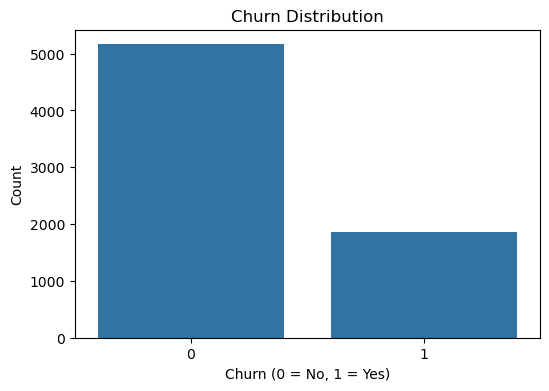

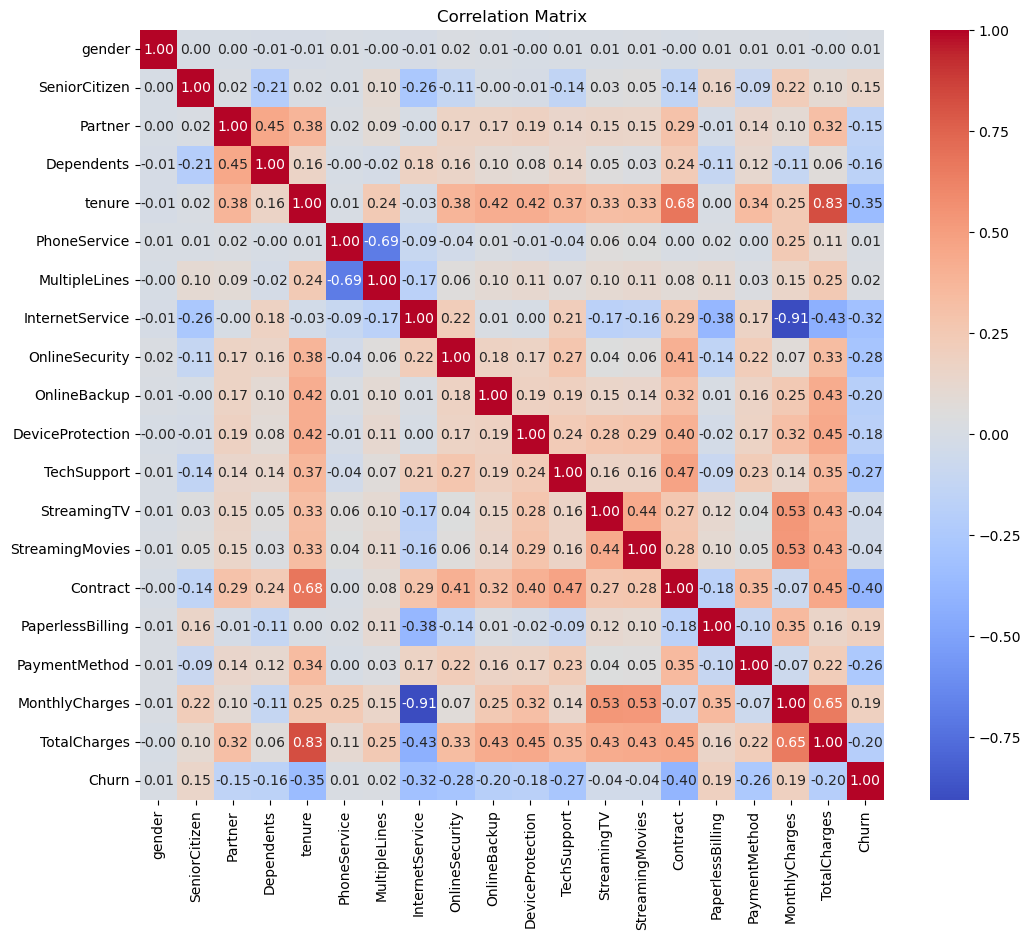

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,4))
sns.countplot(data=df, x='Churn')
plt.title("Churn Distribution")
plt.xlabel("Churn (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(12,10))
sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()


In [4]:
# Adding tenure categories
df['tenure_group'] = pd.cut(df['tenure'], bins=[0, 12, 24, 48, 60, 72],
                            labels=['0-12', '13-24', '25-48', '49-60', '61-72'])
df = pd.get_dummies(df, columns=['tenure_group'], drop_first=True)

#combining Streaming services
df['HasStreaming'] = ((df["StreamingTV"] == 1) | (df["StreamingMovies"] == 1)).astype(int)
df.drop(columns=['StreamingTV', 'StreamingMovies'], inplace=True)


In [5]:
from sklearn.model_selection import train_test_split

X = df.drop("Churn", axis=1)
y = df["Churn"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("🔹 Random Forest Results")
print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("NaNs in X_train:", X_train.isnull().sum())
print("NaNs in X_test:", X_test.isnull().sum())


🔹 Random Forest Results
[[922 111]
 [189 185]]
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1033
           1       0.62      0.49      0.55       374

    accuracy                           0.79      1407
   macro avg       0.73      0.69      0.71      1407
weighted avg       0.78      0.79      0.78      1407

Accuracy: 0.7867803837953091
NaNs in X_train: gender                   0
SeniorCitizen            0
Partner                  0
Dependents               0
tenure                   0
PhoneService             0
MultipleLines            0
InternetService          0
OnlineSecurity        1208
OnlineBackup          1208
DeviceProtection      1208
TechSupport           1208
Contract                 0
PaperlessBilling         0
PaymentMethod            0
MonthlyCharges           0
TotalCharges             0
tenure_group_13-24       0
tenure_group_25-48       0
tenure_group_49-60       0
tenure_group_61-72       0
HasStreaming 

In [7]:
from sklearn.preprocessing import StandardScaler

cols_with_nans = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport']

for col in cols_with_nans:
    X_train[col] = X_train[col].fillna(0)
    X_test[col] = X_test[col].fillna(0)
    
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train_scaled, y_train)
y_pred_knn = knn.predict(X_test_scaled)

print("\n🔹 KNN Results")
print(confusion_matrix(y_test, y_pred_knn))
print(classification_report(y_test, y_pred_knn))
print("Accuracy:", accuracy_score(y_test, y_pred_knn))



🔹 KNN Results
[[863 170]
 [169 205]]
              precision    recall  f1-score   support

           0       0.84      0.84      0.84      1033
           1       0.55      0.55      0.55       374

    accuracy                           0.76      1407
   macro avg       0.69      0.69      0.69      1407
weighted avg       0.76      0.76      0.76      1407

Accuracy: 0.7590618336886994


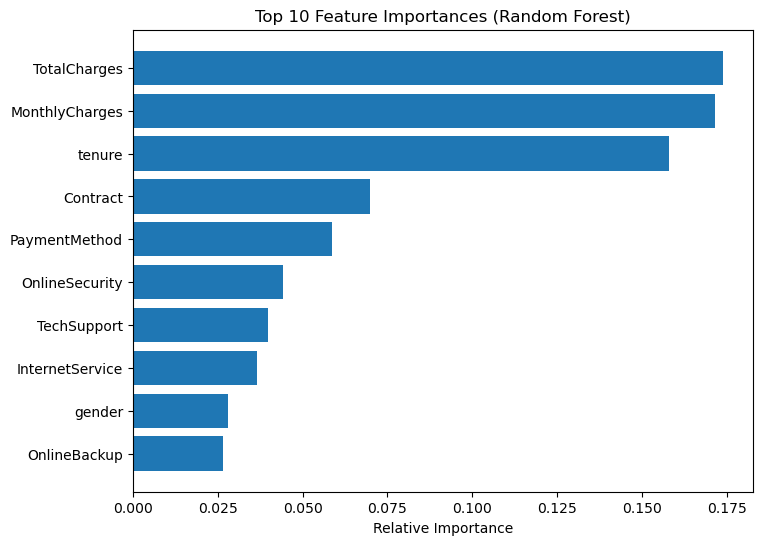

In [8]:
import numpy as np

importances = rf.feature_importances_
indices = np.argsort(importances)[-10:]  # Top 10 features
plt.figure(figsize=(8,6))
plt.title('Top 10 Feature Importances (Random Forest)')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [X.columns[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()


In [9]:
import joblib
joblib.dump(rf, "../model/churn_model.pkl")
joblib.dump(X.columns, "../model/feature_columns.pkl")


['../model/feature_columns.pkl']